MIT License

Copyright (c) 2025 Mohannad Shehadeh

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [1]:
using Dates
using Plots
using Combinatorics
using LinearAlgebra
using Statistics
using DelimitedFiles

NOTE THAT 4-PAM IN THIS CONTEXT IS REFERRING TO 4-PAM IN EACH REAL DEGREE OF FREEDOM WHICH IS EQUIVALENT TO 16-QAM OR **QAM** SPECTRAL EFFICIENCY SINCE WE ARE WORKING WITH REAL-VALUED **EQUIVALENT REPRESENTATIONS** OF A COMPLEX-VALUED MODEL.

In [2]:
include("GF2-LinAlg.jl");

Codes are single-error-correcting, double-error-detecting extended Hamming codes shortened from a parent extended Hamming code of length $2^m$ with $m+1$ parity bits.

An $[n,k]$ code is used for the single-code schemes with parameters as follows:

In [3]:
# some options yielding equal average rates:
# (n,excess_m) = (128,5), (64,3), (256,3)
# (n,excess_m) = (200,4), (100,2), (400,2)
# (n,excess_m) = (192,4), (96,2), (384,2)
# (n,excess_m) = (192,4), (144,4), (288,3) sg

In [4]:
n = 192
excess_m = 4
m = ceil(Int64,log2(n)) + excess_m
s = 2^m - n
k = n-(m+1)
println("m: $m")
println("2^m: $(2^m)")
println("s: $s");
println("n: $n")
println("k: $k")
println("k/n: $(k//n) = $(round(k/n,digits=3))")

m: 12
2^m: 4096
s: 3904
n: 192
k: 179
k/n: 179//192 = 0.932


Two codes, an $[n_1,k_1]$ code and an $[n_2,k_2]$ code, are used for the two-code scheme with the parameters chosen so that the average code rate is exactly the same as for the $[n,k]$ code so that we have a fair and easy comparison:

In [5]:
n_1 = 96
excess_m = 2
m_1 = ceil(Int64,log2(n_1)) + excess_m
s_1 = 2^m_1 - n_1
k_1 = n_1-(m_1+1)
println("m_1: $m_1")
println("2^m_1: $(2^m_1)")
println("s_1: $s_1");
println("n_1: $n_1")
println("k_1: $k_1")
println("k_1/n_1: $(k_1//n_1) = $(round(k_1/n_1,digits=3))")

m_1: 9
2^m_1: 512
s_1: 416
n_1: 96
k_1: 86
k_1/n_1: 43//48 = 0.896


In [6]:
n_2 = 384
excess_m = 2 
m_2 = ceil(Int64,log2(n_2)) + excess_m
s_2 = 2^m_2 - n_2
k_2 = n_2-(m_2+1)
println("m_2: $m_2")
println("2^m_2: $(2^m_2)")
println("s_2: $s_2");
println("n_2: $n_2")
println("k_2: $k_2")
println("k_2/n_2: $(k_2//n_2) = $(round(k_2/n_2,digits=3))")

m_2: 11
2^m_2: 2048
s_2: 1664
n_2: 384
k_2: 372
k_2/n_2: 31//32 = 0.969


The rate of the first code and the average rate of the two-code pair:

In [7]:
display(k//n)
display((k_1//n_1 + k_2//n_2)//2)

179//192

179//192

In [8]:
display(k/n)
display((k_1/n_1 + k_2/n_2)/2)

0.9322916666666666

0.9322916666666667

Various divisibility conditions are needed for the exact scheme variations considered in this notebook:

In [9]:
@assert mod(n,2) == 0
@assert mod(n_1,2) == 0
@assert mod(n_2,2) == 0
half_n = Int64(n/2);
half_n_1 = Int64(n_1/2);
half_n_2 = Int64(n_2/2);

In [10]:
@assert mod(n_2,n_1) == 0
fits = div(n_2,n_1)

4

In [11]:
@assert k/n > 1/2
@assert mod(n,4) == 0
quarter_n = Int64(n/4)

48

In [12]:
@assert mod(n,8) == 0
eighth_n = Int64(n/8)

24

In [13]:
@assert mod(n_2,4) == 0
quarter_n_2 = Int64(n_2/4)

96

In [14]:
# the WRONG precoder to use:
# PREC_G = 1.0/sqrt(2) * 
#         [
#         1 0  1  0; 
#         0 1  0 -1; 
#         0 1  0  1; 
#         1 0 -1  0
#         ]

# the RIGHT precoder to use
PREC_G = 1.0/sqrt(2) * 
        [
        1 0 1 0;
        0 1 0 1; 
        0 1 0 -1; 
        -1 0 1 0
        ]

4×4 Matrix{Float64}:
  0.707107  0.0       0.707107   0.0
  0.0       0.707107  0.0        0.707107
  0.0       0.707107  0.0       -0.707107
 -0.707107  0.0       0.707107   0.0

In [15]:
sum(PREC_G'PREC_G - ones(4,4)^0)

-9.776629923831548e-16

The following creates a systematic extended Hamming code generator matrix $G$, parity-check matrix $H$, its transpose, and the parity/non-identity portion of the generator matrix $P$. This is a special choice of systematic extended Hamming code with a LUT-free decoding method described in [this work](https://arxiv.org/pdf/2312.13415). This is done for all three code parameters defined earlier.

In [16]:
# m a b ainv
special_eHamming = 
[
3 1 1 1;  
4 3 0  11;
5 3 0  11;
6 3 3  43;
7 5 5  77;
8 9 11  57;
9 19 19  27;
10 27 27  531;
11 53 53  541;
12 89 89  2025;
13 163 170  4875;
14 301 308  13989;
15 553 553  14873;
16 1065 1155 55321;
]
if (m < 3 || m > 16)
    throw("Unsupported m!")
end
a = special_eHamming[m-3+1,2]
b = special_eHamming[m-3+1,3] + a*s
ainv = special_eHamming[m-3+1,4]
mask = (1<<m)-1
minus_b = (1<<m)-b

if (m_1 < 3 || m_1 > 16)
    throw("Unsupported m_1!")
end
a_1 = special_eHamming[m_1-3+1,2]
b_1 = special_eHamming[m_1-3+1,3] + a_1*s_1
ainv_1 = special_eHamming[m_1-3+1,4]
mask_1 = (1<<m_1)-1
minus_b_1 = (1<<m_1)-b_1

if (m_2 < 3 || m_2 > 16)
    throw("Unsupported m_2!")
end
a_2 = special_eHamming[m_2-3+1,2]
b_2 = special_eHamming[m_2-3+1,3] + a_2*s_2
ainv_2 = special_eHamming[m_2-3+1,4]
mask_2 = (1<<m_2)-1
minus_b_2 = (1<<m_2)-b_2

synFromErrorloc(x) = (((a*x+b)&mask)<<1)+1
errorlocFromSyn(x) = (ainv*((x>>1)+minus_b))&mask

synFromErrorloc_1(x) = (((a_1*x+b_1)&mask_1)<<1)+1
errorlocFromSyn_1(x) = (ainv_1*((x>>1)+minus_b_1))&mask_1

synFromErrorloc_2(x) = (((a_2*x+b_2)&mask_2)<<1)+1
errorlocFromSyn_2(x) = (ainv_2*((x>>1)+minus_b_2))&mask_2

H = zeros(Int64,m+1,0)
for i in 0:n-1
    H = hcat(H,reverse(digits(synFromErrorloc(i),base=2,pad=m+1))) 
end

H_1 = zeros(Int64,m_1+1,0)
for i in 0:n_1-1
    H_1 = hcat(H_1,reverse(digits(synFromErrorloc_1(i),base=2,pad=m_1+1))) 
end

H_2 = zeros(Int64,m_2+1,0)
for i in 0:n_2-1
    H_2 = hcat(H_2,reverse(digits(synFromErrorloc_2(i),base=2,pad=m_2+1))) 
end

@assert [errorlocFromSyn(synFromErrorloc(x)) for x in 0:n-1] == 0:n-1
@assert [synFromErrorloc(errorlocFromSyn(2*x+1)) for x in 0:n-1] == 2 .* (0:n-1) .+ 1

@assert [errorlocFromSyn_1(synFromErrorloc_1(x)) for x in 0:n_1-1] == 0:n_1-1
@assert [synFromErrorloc_1(errorlocFromSyn_1(2*x+1)) for x in 0:n_1-1] == 2 .* (0:n_1-1) .+ 1

@assert [errorlocFromSyn_2(synFromErrorloc_2(x)) for x in 0:n_2-1] == 0:n_2-1
@assert [synFromErrorloc_2(errorlocFromSyn_2(2*x+1)) for x in 0:n_2-1] == 2 .* (0:n_2-1) .+ 1

G = RREF(dual(H));
@assert G[1:k,1:k] == Int64.(ones(k,k)^0);
@assert sum(mod.(G*transpose(H),2)) == 0;
P = G[:,k+1:n];
Pt = transpose(P);
Ht = transpose(H);

G_1 = RREF(dual(H_1));
@assert G_1[1:k_1,1:k_1] == Int64.(ones(k_1,k_1)^0);
@assert sum(mod.(G_1*transpose(H_1),2)) == 0;
P_1 = G_1[:,k_1+1:n_1];
P_1t = transpose(P_1);
H_1t = transpose(H_1);

G_2 = RREF(dual(H_2));
@assert G_2[1:k_2,1:k_2] == Int64.(ones(k_2,k_2)^0);
@assert sum(mod.(G_2*transpose(H_2),2)) == 0;
P_2 = G_2[:,k_2+1:n_2];
P_2t = transpose(P_2);
H_2t = transpose(H_2);

In [17]:
encode(x) = [x; mod.(Pt*x,2)];
encode_1(x) = [x; mod.(P_1t*x,2)];
encode_2(x) = [x; mod.(P_2t*x,2)];

In [18]:
int_basis_syn = [2^i for i in m:-1:0]';
int_basis_syn_1 = [2^i for i in m_1:-1:0]';
int_basis_syn_2 = [2^i for i in m_2:-1:0]';

In [19]:
function Gray(n)
    if n <= 0
        throw("Invalid n!")
    elseif n == 1
        return [[0],[1]]
    else
        previous = Gray(n-1)
        reflected = reverse(previous)
        pref_0 = [[0; previous[i]] for i in 1:2^(n-1)]
        pref_1 = [[1; reflected[i]] for i in 1:2^(n-1)]
        return [pref_0; pref_1]
    end
end;

In [20]:
nonGray(n) = [reverse(digits(i,base=2,pad=n)) for i = 0:2^n-1];

I will take the convention that we always equalize to energy-normalized input so that

$$
Y_i = X_i + \sigma_iZ_i
$$

where $Z_i\sim\mathcal N(0,1)$ and $\mathbb{E}[X_i^2] = 1$.

I normalize the constellation $\mathcal{S}$ so that
$$
1 = \mathbb{E}[S^2] = \frac{1}{|\mathcal{S}|} \sum_{s\in \mathcal{S}} |s|^2\text{.}
$$
where $S$ is chosen uniformly at random from $\mathcal{S}$.

In [21]:
# PAM2 = [i for i = -1:2:1];
# PAM2 = PAM2 * 1.0 / sqrt(1/2*PAM2'PAM2);

PAM4 = [i for i = -3:2:3];
PAM4 = PAM4 * 1.0 / sqrt(1/4*PAM4'PAM4);

We have a mapping from bits to constellations $b_1 b_2 \dots b_n \longmapsto s$ which we take to be [Gray](https://en.wikipedia.org/wiki/Gray_code).

In [22]:
# PAM2_labels = Gray(1);
# PAM2_labels_int = [PAM2_labels[i] for i in 1:2];
# PAM2_labels_int_inv = sortperm(PAM2_labels_int) .- 1;
# PAM2_label_order = PAM2[PAM2_labels_int_inv .+ 1];

PAM4_labels = Gray(2);
PAM4_labels_int = [dot([2,1],PAM4_labels[i]) for i in 1:4];
PAM4_labels_int_inv = sortperm(PAM4_labels_int) .- 1;
PAM4_label_order = PAM4[PAM4_labels_int_inv .+ 1];

In [23]:
# PAM2_map(b_1) = PAM2_label_order[b_1 + 1];
# PAM2_map_seq(x) = [PAM2_map(x[i]) for i in 1:1:length(x)];

PAM4_map(b_1,b_2) = PAM4_label_order[2*b_1 + b_2 + 1];
PAM4_map_seq(x) = [PAM4_map(x[i],x[i+1]) for i in 1:2:length(x)];

In [24]:
# SIG = PAM2_map_seq(rand(0:1,10000))
# SIG'SIG * 1.0/length(SIG)

SIG = PAM4_map_seq(rand(0:1,10000))
SIG'SIG * 1.0/length(SIG)

1.02272

$$
\text{LLR of ith bit of received symbol y } =  
\log \frac{p(y \mid b_i = 0)}{p(y \mid b_i = 1)} 
= 
\log\frac{\sum_{\text{$s$ in image of $b_1\dots b_{i-1} 0 b_{i+1}\dots b_n$}}\exp\left(-\frac{1}{2\sigma^2}(y-s)^2\right)}{\sum_{\text{$s$ in image of $b_1\dots b_{i-1} 1 b_{i+1}\dots b_n$}}\exp\left(-\frac{1}{2\sigma^2}(y-s)^2\right)}
$$

In [25]:
function getLLRs(ys,nvars)
    local n = length(ys);
    # LLRs = zeros(n); # PAM2
    LLRs = zeros(2*n); # PAM4
    for i in 1:n    
        local y = ys[i]
        ν = 1.0/nvars[i];
        # PAM2
        # LLRs[i] = 
        #         log( ( exp(-0.5*ν*(y-PAM2_map(0))^2)  ) /
        #              ( exp(-0.5*ν*(y-PAM2_map(1))^2)  ) );

        # PAM4
        LLRs[2*(i-1)+1] = 
                log( ( exp(-0.5*ν*(y-PAM4_map(0,0))^2) + exp(-0.5*ν*(y-PAM4_map(0,1))^2) ) /
                     ( exp(-0.5*ν*(y-PAM4_map(1,0))^2) + exp(-0.5*ν*(y-PAM4_map(1,1))^2) ) );
        LLRs[2*(i-1)+2] = 
                log( ( exp(-0.5*ν*(y-PAM4_map(0,0))^2) + exp(-0.5*ν*(y-PAM4_map(1,0))^2) ) /
                     ( exp(-0.5*ν*(y-PAM4_map(0,1))^2) + exp(-0.5*ν*(y-PAM4_map(1,1))^2) ) );        
    end
    return LLRs
end;

decider(x) = div(1-Int64(sign(x)), 2);

### Chase decoder
Test all combinations of $0$ to $w$ bit flips in the $q$ least reliable positions for a total of 
$$
\binom{q}{0} + \binom{q}{1} + \binom{q}{2} + \cdots + \binom{q}{w}
$$
test patterns.

In [26]:
function Chase_decode(c, q, w)
    y = decider.(c);
    if w == -1
        return y
    end
    abs_c = abs.(c);
    syn = int_basis_syn * mod.(H*y,2);
    if syn == 0
        return y
    elseif syn & 0x01 == 1 # odd parity y
        # only even-sized perturbations can make the decoder do anything
        size_set = 0:2:w
    else # even parity y
        # only odd-sized perturbations can make the decoder do anything
        size_set = 1:2:w
    end
    least_reliable_positions = sortperm(abs_c,rev=false)[1:q];
    smallest_analog_weight = Inf;
    correction = zeros(Int64,n);
    test_pattern = zeros(Int64,n);
    for size in size_set
        for comb in combinations(least_reliable_positions, size)
            new_syn = syn;
            test_pattern *= 0;
            analog_weight = 0;
            for j in comb
                new_syn ⊻= synFromErrorloc(j .- 1)
                test_pattern[j] ⊻= 1;
                analog_weight += abs_c[j];
            end
            errorloc = errorlocFromSyn(new_syn) + 1;
            if errorloc <= n
                if test_pattern[errorloc] == 1
                    analog_weight -= abs_c[errorloc]
                    test_pattern[errorloc] ⊻= 1
                else
                    analog_weight += abs_c[errorloc]
                    test_pattern[errorloc] ⊻= 1
                end
                if analog_weight < smallest_analog_weight
                    smallest_analog_weight = analog_weight;
                    correction = test_pattern
                end
            end
        end
    end
    return y .⊻ correction
end;

In [27]:
function Chase_decode_1(c, q, w)
    y = decider.(c);
    if w == -1
        return y
    end
    abs_c = abs.(c);
    syn = int_basis_syn_1 * mod.(H_1*y,2);
    if syn == 0
        return y
    elseif syn & 0x01 == 1 # odd parity y
        # only even-sized perturbations can make the decoder do anything
        size_set = 0:2:w
    else # even parity y
        # only odd-sized perturbations can make the decoder do anything
        size_set = 1:2:w
    end
    least_reliable_positions = sortperm(abs_c,rev=false)[1:q];
    smallest_analog_weight = Inf;
    correction = zeros(Int64,n_1);
    test_pattern = zeros(Int64,n_1);
    for size in size_set
        for comb in combinations(least_reliable_positions, size)
            new_syn = syn;
            test_pattern *= 0;
            analog_weight = 0;
            for j in comb
                new_syn ⊻= synFromErrorloc_1(j .- 1)
                test_pattern[j] ⊻= 1;
                analog_weight += abs_c[j];
            end
            errorloc = errorlocFromSyn_1(new_syn) + 1;
            if errorloc <= n_1
                if test_pattern[errorloc] == 1
                    analog_weight -= abs_c[errorloc]
                    test_pattern[errorloc] ⊻= 1
                else
                    analog_weight += abs_c[errorloc]
                    test_pattern[errorloc] ⊻= 1
                end
                if analog_weight < smallest_analog_weight
                    smallest_analog_weight = analog_weight;
                    correction = test_pattern
                end
            end
        end
    end
    return y .⊻ correction
end;

In [28]:
function Chase_decode_2(c, q, w)
    y = decider.(c);
    if w == -1
        return y
    end
    abs_c = abs.(c);
    syn = int_basis_syn_2 * mod.(H_2*y,2);
    if syn == 0
        return y
    elseif syn & 0x01 == 1 # odd parity y
        # only even-sized perturbations can make the decoder do anything
        size_set = 0:2:w
    else # even parity y
        # only odd-sized perturbations can make the decoder do anything
        size_set = 1:2:w
    end
    least_reliable_positions = sortperm(abs_c,rev=false)[1:q];
    smallest_analog_weight = Inf;
    correction = zeros(Int64,n_2);
    test_pattern = zeros(Int64,n_2);
    for size in size_set
        for comb in combinations(least_reliable_positions, size)
            new_syn = syn;
            test_pattern *= 0;
            analog_weight = 0;
            for j in comb
                new_syn ⊻= synFromErrorloc_2(j .- 1)
                test_pattern[j] ⊻= 1;
                analog_weight += abs_c[j];
            end
            errorloc = errorlocFromSyn_2(new_syn) + 1;
            if errorloc <= n_2
                if test_pattern[errorloc] == 1
                    analog_weight -= abs_c[errorloc]
                    test_pattern[errorloc] ⊻= 1
                else
                    analog_weight += abs_c[errorloc]
                    test_pattern[errorloc] ⊻= 1
                end
                if analog_weight < smallest_analog_weight
                    smallest_analog_weight = analog_weight;
                    correction = test_pattern
                end
            end
        end
    end
    return y .⊻ correction
end;

In [29]:
function channel_matrix(γ,θ)
    return  [sqrt(1.0+γ)  0.0;
             0.0          sqrt(1.0-γ)]*
            [cos(θ) -sin(θ);
             sin(θ)  cos(θ)]
end;

In [30]:
function channel_matrix_2cu(γ,θ)
    return [channel_matrix(γ,θ) zeros(2,2);
            zeros(2,2)          channel_matrix(γ,θ)];
end;

### Scenario 1: (baseline) one code, temporal-interleaving, zero-forcing: TI-ZF
Two codewords are interleaved across two polarizations as follows: The odd position symbols of the first codeword and the even position symbols of the second codeword go on the first polarization while the odd position symbols of the second codeword and the even position symbols of the first codeword go on the second polarization. The receiver inverts the channel and decodes each codeword independently. There is no point of attempting to exploit correlation here because there is a channel instance in the adversarial class where the correlation does not exist.  

In [31]:
function Scenario_1_sim(SNR,γ,θ,q,w)
    mess_1 = rand(0:1,k)
    mess_2 = rand(0:1,k)
    tx_1 = PAM4_map_seq(encode(mess_1)) # length half_n
    tx_2 = PAM4_map_seq(encode(mess_2)) # length half_n
    X = zeros(2,half_n)
    X[1,1:2:end] = tx_1[1:2:end]
    X[1,2:2:end] = tx_2[2:2:end]
    X[2,1:2:end] = tx_2[1:2:end]
    X[2,2:2:end] = tx_1[2:2:end]
    H = channel_matrix(γ,θ);
    H_inv = inv(H)
    Y = H*X + 1.0/sqrt(SNR)*randn(2,half_n)
    Y_EQ = H_inv*Y
    noise_covariance = 1.0/SNR * (H_inv*H_inv')
    noise_variances_1 = ones(half_n);
    noise_variances_2 = ones(half_n);
    rx_1 = zeros(half_n)
    rx_2 = zeros(half_n)
    rx_1[1:2:end] = Y_EQ[1,1:2:end]
    rx_1[2:2:end] = Y_EQ[2,2:2:end]
    noise_variances_1[1:2:end] .= noise_covariance[1,1]
    noise_variances_1[2:2:end] .= noise_covariance[2,2]
    rx_2[1:2:end] = Y_EQ[2,1:2:end]
    rx_2[2:2:end] = Y_EQ[1,2:2:end]
    noise_variances_2[1:2:end] .= noise_covariance[2,2]
    noise_variances_2[2:2:end] .= noise_covariance[1,1]
    
    decoded_1 = Chase_decode(getLLRs(rx_1,noise_variances_1),q,w)
    decoded_2 = Chase_decode(getLLRs(rx_2,noise_variances_2),q,w)
    
    return (sum(mess_1 .!= decoded_1[1:k])+sum(mess_2 .!= decoded_2[1:k])), (k+k)
end;

### Scenario 2: single-code ZF with precoding
* Consider two channel use extension
* Use orthogonal precoder
    $$
      \frac{1}{\sqrt{2}}
      \begin{pmatrix}
          1 & 0 & 1 & 0\\
          0 & 1 & 0 & 1\\
          0 & 1 & 0 & -1\\
          -1 & 0 & 1 & 0
      \end{pmatrix}
    $$

In [32]:
function Scenario_2_sim(SNR,γ,θ,q,w)
    # PREC_G = 1.0/sqrt(2) * [1 0 1 0; 0 1 0 1; 0 1 0 -1; -1 0 1 0];
    mess_1 = rand(0:1,k)
    mess_2 = rand(0:1,k)
    tx_1 = PAM4_map_seq(encode(mess_1)) # length half_n
    tx_2 = PAM4_map_seq(encode(mess_2)) # length half_n
    U = zeros(4,quarter_n)
    U[1,:] = tx_1[1:quarter_n]
    U[2,:] = tx_1[quarter_n+1:end]
    U[3,:] = tx_2[1:quarter_n]
    U[4,:] = tx_2[quarter_n+1:end]
    X = PREC_G*U
    H = sqrt(SNR)*channel_matrix_2cu(γ,θ);
    Y = H*X + randn(4,quarter_n)
    H_inv = inv(H*PREC_G)
    Y_EQ = H_inv*Y
    noise_covariance = H_inv*H_inv'
    noise_variances_1 = ones(half_n);
    noise_variances_2 = ones(half_n);
    rx_1 = zeros(half_n)
    rx_2 = zeros(half_n)
    rx_1[1:quarter_n] = Y_EQ[1,1:quarter_n]
    rx_1[quarter_n+1:end] = Y_EQ[2,1:quarter_n]
    noise_variances_1[1:quarter_n] .= noise_covariance[1,1]
    noise_variances_1[quarter_n+1:end] .= noise_covariance[2,2]
    rx_2[1:quarter_n] = Y_EQ[3,1:quarter_n]
    rx_2[quarter_n+1:end] = Y_EQ[4,1:quarter_n]
    noise_variances_2[1:quarter_n] .= noise_covariance[3,3]
    noise_variances_2[quarter_n+1:end] .= noise_covariance[4,4]
    decoded_1 = Chase_decode(getLLRs(rx_1,noise_variances_1),q,w)
    decoded_2 = Chase_decode(getLLRs(rx_2,noise_variances_2),q,w)
    return (sum(mess_1 .!= decoded_1[1:k])+sum(mess_2 .!= decoded_2[1:k])), (k+k)
end;

### Scenario 3: single-code D-BLAST ZF-SIC without precoding
* D-BLAST architecture:
$$
  \begin{pmatrix}
      \psi & \mathbf x_1^s & \mathbf x_2^s & \cdots & \mathbf x_{\zeta-2}^s & \mathbf x_{\zeta-1}^s & \mathbf x_\zeta^s\\
      \mathbf x_1^f & \mathbf x_2^f &  \mathbf x_3^f & \cdots & \mathbf x_{\zeta-1}^f & \mathbf x_\zeta^f & \psi
  \end{pmatrix}
$$
*  Rate will be $$
      \frac{\zeta}{\zeta+1} \cdot \frac{k}{n}
    $$
* Equalization is generally a Moore–Penrose pseudoinverse
* For each column:
* Equalize. Extract second half of noisy codeword, append to noisy first-half from previous channel use, and decode to produce second-half estimate. Deliver this full codeword. If this is the first column, skip all of this and simply simply produce $\psi$ which is fixed and known as the second-half estimate for the next step.
* Cancel the interference corresponding to the second-half estimate and re-equalize. Overwrite the noisy first-half from the previous channel use with this result. If this is the last column, skip this step.

In [33]:
function Scenario_3_sim(SNR,γ,θ,q,w,ζ)
    messes = rand(0:1,k,ζ) # ζ messages of length k
    cws_hat = zeros(Int64,n,ζ);
    # encode and map to ζ sequences of length half_n:
    xs = [PAM4_map_seq(encode(messes[:,j])) for j in 1:ζ] 
    ψ = PAM4_map_seq(zeros(Int64,half_n)); # becomes quarter_n
    X = zeros(2,quarter_n*(ζ+1));
    # ζ+1 "columns" of width quarter_n
    # column 1
    X[1,1:quarter_n] = ψ
    X[2,1:quarter_n] = xs[1][1:quarter_n];
    # columns 2 to ζ
    for col in 2:ζ
        X[1, 1 + (col-1)*quarter_n : quarter_n + (col-1)*quarter_n] = xs[col-1][quarter_n+1:end];
        X[2, 1 + (col-1)*quarter_n : quarter_n + (col-1)*quarter_n] = xs[col][1:quarter_n];
    end
    # column ζ+1
    X[1, 1 + (ζ)*quarter_n : (ζ+1)*quarter_n] = xs[ζ][quarter_n+1:end];
    X[2, 1 + (ζ)*quarter_n : (ζ+1)*quarter_n] = ψ;
    # pre-compute equalizers and noise stats based on channel knowledge
    H = sqrt(SNR)*channel_matrix(γ,θ);
    EQ_F = inv(H)
    EQ_H = pinv(H[:,2])
    noise_covars_F = EQ_F*EQ_F'
    noise_covars_H = EQ_H*EQ_H'
    noise_vars = ones(half_n);
    # second half of codeword sees EQ_F in first dimension
    noise_vars[quarter_n+1:end] .= noise_covars_F[1,1]
    # first half of codeword sees EQ_H in its only dimension 
    noise_vars[1:quarter_n] .= noise_covars_H[1,1]
    # transmit
    Y = H*X + randn(2,quarter_n*(ζ+1))
    # ZF-SIC
    # first col step
    Y_CUR = Y[:,1:quarter_n];
    Y_CUR = Y_CUR - H[:,1]*ψ';
    noisy_first_half = EQ_H*Y_CUR
    # col 2 to ζ steps delivering codewords 1 to ζ-1
    for col in 2:ζ
        Y_CUR = Y[:,1+(col-1)*quarter_n:quarter_n+(col-1)*quarter_n]
        Y_EQ = EQ_F*Y_CUR
        cws_hat[:,col-1] = Chase_decode(getLLRs([noisy_first_half'; Y_EQ[1,:]],noise_vars),q,w)
        second_half_estimate = PAM4_map_seq(cws_hat[half_n+1:end,col-1]) 
        # second_half_estimate = PAM4_map_seq(encode(messes[:,col-1])[half_n+1:end]) # genie aided version of above line
        Y_CUR = Y_CUR - H[:,1]*second_half_estimate';
        noisy_first_half = EQ_H*Y_CUR
    end
    # col ζ+1 step delivering codeword ζ
    Y_CUR = Y[:,1 + (ζ)*quarter_n : (ζ+1)*quarter_n]
    Y_EQ = EQ_F*Y_CUR
    cws_hat[:,ζ] = Chase_decode(getLLRs([noisy_first_half'; Y_EQ[1,:]],noise_vars),q,w)
    bits_tx = 0
    bit_errs = 0
    for j in 1:ζ
        bits_tx += k
        bit_errs += sum(messes[:,j] .!= cws_hat[1:k,j])
    end
    return bit_errs, bits_tx
end;

### Scenario 4: single-code D-BLAST ZF-SIC with precoding
* Consider two channel use extension
* Use orthogonal precoder from Scenario 2
* The input to the effective $4 \times 4$ looks like this:
$$
  \begin{pmatrix}
      \psi & \mathbf u_1^s & \mathbf u_2^s & \cdots & \mathbf u_{\zeta-2}^s & \mathbf u_{\zeta-1}^s & \mathbf u_\zeta^s\\
      \mathbf u_1^f & \mathbf u_2^f &  \mathbf u_3^f & \cdots & \mathbf u_{\zeta-1}^f & \mathbf u_\zeta^f & \psi
  \end{pmatrix}
$$
*  Rate will be $$
      \frac{\zeta}{\zeta+1} \cdot \frac{k}{n}
    $$
* Equalization is generally a Moore–Penrose pseudoinverse
* For each column:
* Equalize. Extract second half of noisy codeword, append to noisy first-half from previous channel use, and decode to produce second-half estimate. Deliver this full codeword. If this is the first column, skip all of this and simply simply produce $\psi$ which is fixed and known as the second-half estimate for the next step.
* Cancel the interference corresponding to the second-half estimate and re-equalize. Overwrite the noisy first-half from the previous channel use with this result. If this is the last column, skip this step.

In [34]:
function Scenario_4_sim(SNR,γ,θ,q,w,ζ)
    # PREC_G = 1.0/sqrt(2) * [1 0 1 0; 0 1 0 1; 0 1 0 -1; -1 0 1 0];
    messes = rand(0:1,k,ζ) # ζ messages of length k
    cws_hat = zeros(Int64,n,ζ);
    # encode and map to ζ sequences of length half_n:
    us = [PAM4_map_seq(encode(messes[:,j])) for j in 1:ζ] 
    ψ = [PAM4_map_seq(zeros(Int64,quarter_n))'; PAM4_map_seq(zeros(Int64,quarter_n))']; # 2 x eighth_n
    U = zeros(4,eighth_n*(ζ+1));
    # ζ+1 "columns" of dimensions 4 x eighth_n
    # column 1
    U[1:2,1:eighth_n] = ψ
    U[3:4,1:eighth_n] = [us[1][1:eighth_n]'; us[1][eighth_n+1:quarter_n]'];
    # columns 2 to ζ
    for col in 2:ζ
        U[1:2, 1 + (col-1)*eighth_n : eighth_n + (col-1)*eighth_n] = 
                    [us[col-1][quarter_n+1:quarter_n+eighth_n]'; us[col-1][quarter_n+eighth_n+1:half_n]'];
        U[3:4, 1 + (col-1)*eighth_n : eighth_n + (col-1)*eighth_n] =
                    [us[col][1:eighth_n]'; us[col][eighth_n+1:quarter_n]'];
    end
    # column ζ+1
    U[1:2, 1 + (ζ)*eighth_n : (ζ+1)*eighth_n] = 
                    [us[ζ][quarter_n+1:quarter_n+eighth_n]'; us[ζ][quarter_n+eighth_n+1:half_n]'];
    U[3:4, 1 + (ζ)*eighth_n : (ζ+1)*eighth_n] = ψ;
    X = PREC_G*U
    # pre-compute equalizers and noise stats based on channel knowledge
    H = sqrt(SNR)*channel_matrix_2cu(γ,θ);
    H_eff = H*PREC_G;
    EQ_F = inv(H_eff)
    EQ_H = pinv(H_eff[:,3:4])
    noise_covars_F = EQ_F*EQ_F'
    noise_covars_H = EQ_H*EQ_H'
    noise_vars = ones(half_n);
    # second half of codeword sees EQ_F in first and second dimensions
    noise_vars[quarter_n+1:quarter_n+eighth_n] .= noise_covars_F[1,1]
    noise_vars[quarter_n+eighth_n+1:half_n] .= noise_covars_F[2,2]
    # first half of codeword sees EQ_H in first and second dimensions (its only dimensions)
    noise_vars[1:eighth_n] .= noise_covars_H[1,1]
    noise_vars[eighth_n+1:quarter_n] .= noise_covars_H[2,2]
    # transmit
    Y = H*X + randn(4,eighth_n*(ζ+1))
    # ZF-SIC
    # first col step
    Y_CUR = Y[:,1:eighth_n];
    Y_CUR = Y_CUR - H_eff[:,1:2]*ψ;
    noisy_first_half = EQ_H*Y_CUR
    # col 2 to ζ steps delivering codewords 1 to ζ-1
    for col in 2:ζ
        Y_CUR = Y[:,1+(col-1)*eighth_n:eighth_n+(col-1)*eighth_n]
        Y_EQ = EQ_F*Y_CUR
        cws_hat[:,col-1] = Chase_decode(getLLRs([noisy_first_half[1,:]; noisy_first_half[2,:]; Y_EQ[1,:]; Y_EQ[2,:]],noise_vars),q,w)
        second_half_estimate = PAM4_map_seq(cws_hat[half_n+1:end,col-1]) 
        # second_half_estimate = PAM4_map_seq(encode(messes[:,col-1])[half_n+1:end]) # genie aided version of above line
        Y_CUR = Y_CUR - H_eff[:,1:2]*[second_half_estimate[1:eighth_n]'; second_half_estimate[eighth_n+1:end]'] ;
        noisy_first_half = EQ_H*Y_CUR
    end
    # col ζ+1 step delivering codeword ζ
    Y_CUR = Y[:,1 + (ζ)*eighth_n : (ζ+1)*eighth_n]
    Y_EQ = EQ_F*Y_CUR
    cws_hat[:,ζ] = Chase_decode(getLLRs([noisy_first_half[1,:]; noisy_first_half[2,:]; Y_EQ[1,:]; Y_EQ[2,:]],noise_vars),q,w)
    bits_tx = 0
    bit_errs = 0
    for j in 1:ζ
        bits_tx += k
        bit_errs += sum(messes[:,j] .!= cws_hat[1:k,j])
    end
    return bit_errs, bits_tx
end;

### Scenario 5: two-code ZF-SIC with precoding, as prescribed in [my work](https://doi.org/10.1109/JLT.2022.3230266)
* Consider two channel use extension
* Use orthogonal precoder
    $$
      \frac{1}{\sqrt{2}}
      \begin{pmatrix}
          1 & 0 & 1 & 0\\
          0 & 1 & 0 & 1\\
          0 & 1 & 0 & -1\\
          -1 & 0 & 1 & 0
      \end{pmatrix}
    $$
* Use **two codes** and decode the lower rate code first
* Use that result of that decoding to perform interference cancellation before re-equalizing and decoding the higher rate code
* We choose the codes so that
      $$
          \frac{1}{2}\left(\frac{k_1}{n_1} + \frac{k_2}{n_2}\right) = \frac{k}{n}
      $$
  which is our overall rate

In [35]:
(k_1*fits + k_2)//(n_1*fits+n_2)

179//192

In [36]:
(k_1*fits + k_2)

716

In [37]:
(n_1*fits+n_2)

768

In [38]:
function Scenario_5_sim(SNR,γ,θ,q,w)
    # PREC_G = 1.0/sqrt(2) * [1 0 1 0; 0 1 0 1; 0 1 0 -1; -1 0 1 0];
    mess_1 = [rand(0:1,k_1) for fit in 1:fits] # sending "fits" number of codewords from code 1
    mess_2 = rand(0:1,k_2)
    # fits = n_2/n_1
    tx_1 = PAM4_map_seq(encode_1(mess_1[1])) 
    for fit in 2:fits
        tx_1 = [tx_1; PAM4_map_seq(encode_1(mess_1[fit]))]
    end
    # tx_1 length is n_1*fits/2 = n_1*n_2/n_1/2 = n_2/2 = half_n_2
    tx_2 = PAM4_map_seq(encode_2(mess_2)) # length half_n_2
    U = zeros(4,quarter_n_2)
    U[1,:] = tx_1[1:quarter_n_2]
    U[2,:] = tx_1[quarter_n_2+1:end]
    U[3,:] = tx_2[1:quarter_n_2]
    U[4,:] = tx_2[quarter_n_2+1:end]
    # precode and transmit
    X = PREC_G*U
    H = sqrt(SNR)*channel_matrix_2cu(γ,θ);
    Y = H*X + randn(4,quarter_n_2)

    # pre-compute equalizers and noise stats based on channel knowledge
    H_eff = H*PREC_G
    EQ_1 = inv(H_eff)
    EQ_2 = pinv(H_eff[:,3:4])
    noise_covars_1 = EQ_1*EQ_1'
    noise_covars_2 = EQ_2*EQ_2'
    noise_vars_1 = ones(half_n_2);
    noise_vars_2 = ones(half_n_2);
    rx_1 = zeros(half_n_2)
    rx_2 = zeros(half_n_2)

    # decode first codewords ("fits" number of these)
    Y_EQ_1 = EQ_1*Y
    rx_1[1:quarter_n_2] = Y_EQ_1[1,1:quarter_n_2]
    rx_1[quarter_n_2+1:end] = Y_EQ_1[2,1:quarter_n_2]
    noise_vars_1[1:quarter_n_2] .= noise_covars_1[1,1]
    noise_vars_1[quarter_n_2+1:end] .= noise_covars_1[2,2]
    
    decoded_1 = 
        [Chase_decode_1(getLLRs(rx_1[1+(fit-1)*half_n_1:half_n_1+(fit-1)*half_n_1],
                noise_vars_1[1+(fit-1)*half_n_1:half_n_1+(fit-1)*half_n_1]),q,w) for fit in 1:fits];
    
    # cancel interference and re-equalize
    tx_1_estimate = PAM4_map_seq(decoded_1[1]) 
    for fit in 2:fits
        tx_1_estimate = [tx_1_estimate; PAM4_map_seq(decoded_1[fit])]
    end
    U_first_half_estimate = zeros(2,quarter_n_2)
    U_first_half_estimate[1,:] = tx_1_estimate[1:quarter_n_2]
    U_first_half_estimate[2,:] = tx_1_estimate[quarter_n_2+1:end]
    # U_first_half_estimate = U[1:2,:] # genie-aided version of above
    Y_EQ_2 = EQ_2*(Y - H_eff[:,1:2]*U_first_half_estimate);

    # decode second codeword
    rx_2[1:quarter_n_2] = Y_EQ_2[1,1:quarter_n_2]
    rx_2[quarter_n_2+1:end] = Y_EQ_2[2,1:quarter_n_2]
    noise_vars_2[1:quarter_n_2] .= noise_covars_2[1,1]
    noise_vars_2[quarter_n_2+1:end] .= noise_covars_2[2,2]
    decoded_2 = Chase_decode_2(getLLRs(rx_2,noise_vars_2),q,w)
    
    return ((sum([sum(mess_1[fit] .!= decoded_1[fit][1:k_1]) for fit in 1:fits]) + sum(mess_2 .!= decoded_2[1:k_2])), (fits*k_1+k_2))
end;

In [39]:
SNR_dBs = 11:0.25:18
SNRs = 10 .^ (SNR_dBs ./ 10)
display(SNR_dBs')

1×29 adjoint(::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}) with eltype Float64:
 11.0  11.25  11.5  11.75  12.0  12.25  …  17.0  17.25  17.5  17.75  18.0

In [40]:
Scen3_D_BLAST_PARAM = 100;
Scen4_D_BLAST_PARAM = Scen3_D_BLAST_PARAM;

In [41]:
Chase_q = 6
Chase_w = 4

4

In [42]:
fileNamePrefix = "6dB_"
α = 0.599

0.599

In [43]:
10*log10((1+α)/(1-α))

6.007040911260524

In [44]:
γs = collect(-1:1/2:1)'*α
θs = collect(0:1/16:1)'*2*π
display(γs)
display(θs)

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 -0.599  -0.2995  0.0  0.2995  0.599

1×17 adjoint(::Vector{Float64}) with eltype Float64:
 0.0  0.392699  0.785398  1.1781  …  5.10509  5.49779  5.89049  6.28319

In [45]:
bit_errs_to_find = 10*10000
target_BER = 1e-3
# bit_errs_to_find = 1000
# target_BER = 1e-2

bit_err_cts_Scen1 = zeros(Int64,length(γs),length(θs),length(SNRs));
bit_tx_cts_Scen1 = zeros(Int64,length(γs),length(θs),length(SNRs));
BERs_Scen1 = zeros(length(γs),length(θs),length(SNRs));

bit_err_cts_Scen2 = zeros(Int64,length(γs),length(θs),length(SNRs));
bit_tx_cts_Scen2 = zeros(Int64,length(γs),length(θs),length(SNRs));
BERs_Scen2 = zeros(length(γs),length(θs),length(SNRs));

bit_err_cts_Scen3 = zeros(Int64,length(γs),length(θs),length(SNRs));
bit_tx_cts_Scen3 = zeros(Int64,length(γs),length(θs),length(SNRs));
BERs_Scen3 = zeros(length(γs),length(θs),length(SNRs));

bit_err_cts_Scen4 = zeros(Int64,length(γs),length(θs),length(SNRs));
bit_tx_cts_Scen4 = zeros(Int64,length(γs),length(θs),length(SNRs));
BERs_Scen4 = zeros(length(γs),length(θs),length(SNRs));

bit_err_cts_Scen5 = zeros(Int64,length(γs),length(θs),length(SNRs));
bit_tx_cts_Scen5 = zeros(Int64,length(γs),length(θs),length(SNRs));
BERs_Scen5 = zeros(length(γs),length(θs),length(SNRs));

t_0 = now()
# Scenario 1
for i in 1:length(γs)
    for j in 1:length(θs)
        for point in 1:length(SNRs)
            if i == 1 && j == 1
                println("Scenario 1: SNR $point/$(length(SNRs))")
            end
            while bit_err_cts_Scen1[i,j,point] < bit_errs_to_find
                num_bit_errors, num_bits_trans = Scenario_1_sim(SNRs[point],γs[i],θs[j],Chase_q,Chase_w)
                bit_err_cts_Scen1[i,j,point] += num_bit_errors
                bit_tx_cts_Scen1[i,j,point] += num_bits_trans
            end
            BERs_Scen1[i,j,point] = bit_err_cts_Scen1[i,j,point] / bit_tx_cts_Scen1[i,j,point]
            if BERs_Scen1[i,j,point] < target_BER
                break
            end
        end
    end
end
# End of scenario 1
# Scenario 2
for i in 1:length(γs)
    for j in 1:length(θs)
        for point in 1:length(SNRs)
            if i == 1 && j == 1
                println("Scenario 2: SNR $point/$(length(SNRs))")
            end
            while bit_err_cts_Scen2[i,j,point] < bit_errs_to_find
                num_bit_errors, num_bits_trans = Scenario_2_sim(SNRs[point],γs[i],θs[j],Chase_q,Chase_w)
                bit_err_cts_Scen2[i,j,point] += num_bit_errors
                bit_tx_cts_Scen2[i,j,point] += num_bits_trans
            end
            BERs_Scen2[i,j,point] = bit_err_cts_Scen2[i,j,point] / bit_tx_cts_Scen2[i,j,point]
            if BERs_Scen2[i,j,point] < target_BER
                break
            end
        end
    end
end
# End of scenario 2
# Scenario 3
for i in 1:length(γs)
    for j in 1:length(θs)
        for point in 1:length(SNRs)
            if i == 1 && j == 1
                println("Scenario 3: SNR $point/$(length(SNRs))")
            end
            while bit_err_cts_Scen3[i,j,point] < bit_errs_to_find
                num_bit_errors, num_bits_trans = Scenario_3_sim(SNRs[point],γs[i],θs[j],Chase_q,Chase_w,Scen3_D_BLAST_PARAM)
                bit_err_cts_Scen3[i,j,point] += num_bit_errors
                bit_tx_cts_Scen3[i,j,point] += num_bits_trans
            end
            BERs_Scen3[i,j,point] = bit_err_cts_Scen3[i,j,point] / bit_tx_cts_Scen3[i,j,point]
            if BERs_Scen3[i,j,point] < target_BER
                break
            end
        end
    end
end
# End of scenario 3
# Scenario 4
for i in 1:length(γs)
    for j in 1:length(θs)
        for point in 1:length(SNRs)
            if i == 1 && j == 1
                println("Scenario 4: SNR $point/$(length(SNRs))")
            end
            while bit_err_cts_Scen4[i,j,point] < bit_errs_to_find
                num_bit_errors, num_bits_trans = Scenario_4_sim(SNRs[point],γs[i],θs[j],Chase_q,Chase_w,Scen4_D_BLAST_PARAM)
                bit_err_cts_Scen4[i,j,point] += num_bit_errors
                bit_tx_cts_Scen4[i,j,point] += num_bits_trans
            end
            BERs_Scen4[i,j,point] = bit_err_cts_Scen4[i,j,point] / bit_tx_cts_Scen4[i,j,point]
            if BERs_Scen4[i,j,point] < target_BER
                break
            end
        end
    end
end
# End of scenario 4
# Scenario 5
for i in 1:length(γs)
    for j in 1:length(θs)
        for point in 1:length(SNRs)
            if i == 1 && j == 1
                println("Scenario 5: SNR $point/$(length(SNRs))")
            end
            while bit_err_cts_Scen5[i,j,point] < bit_errs_to_find
                num_bit_errors, num_bits_trans = Scenario_5_sim(SNRs[point],γs[i],θs[j],Chase_q,Chase_w)
                bit_err_cts_Scen5[i,j,point] += num_bit_errors
                bit_tx_cts_Scen5[i,j,point] += num_bits_trans
            end
            BERs_Scen5[i,j,point] = bit_err_cts_Scen5[i,j,point] / bit_tx_cts_Scen5[i,j,point]
            if BERs_Scen5[i,j,point] < target_BER
                break
            end
        end
    end
end
# End of scenario 5
t_1 = now()

Scenario 1: SNR 1/29
Scenario 1: SNR 2/29
Scenario 1: SNR 3/29
Scenario 1: SNR 4/29
Scenario 1: SNR 5/29
Scenario 1: SNR 6/29
Scenario 1: SNR 7/29
Scenario 1: SNR 8/29
Scenario 1: SNR 9/29
Scenario 1: SNR 10/29
Scenario 1: SNR 11/29
Scenario 1: SNR 12/29
Scenario 1: SNR 13/29
Scenario 1: SNR 14/29
Scenario 1: SNR 15/29
Scenario 1: SNR 16/29
Scenario 1: SNR 17/29
Scenario 1: SNR 18/29
Scenario 1: SNR 19/29
Scenario 1: SNR 20/29
Scenario 1: SNR 21/29
Scenario 1: SNR 22/29
Scenario 1: SNR 23/29
Scenario 1: SNR 24/29
Scenario 1: SNR 25/29
Scenario 1: SNR 26/29
Scenario 1: SNR 27/29
Scenario 2: SNR 1/29
Scenario 2: SNR 2/29
Scenario 2: SNR 3/29
Scenario 2: SNR 4/29
Scenario 2: SNR 5/29
Scenario 2: SNR 6/29
Scenario 2: SNR 7/29
Scenario 2: SNR 8/29
Scenario 2: SNR 9/29
Scenario 2: SNR 10/29
Scenario 2: SNR 11/29
Scenario 2: SNR 12/29
Scenario 2: SNR 13/29
Scenario 2: SNR 14/29
Scenario 2: SNR 15/29
Scenario 2: SNR 16/29
Scenario 2: SNR 17/29
Scenario 2: SNR 18/29
Scenario 2: SNR 19/29
Scenar

2025-03-12T15:02:22.006

In [46]:
println("Simulation duration in different units:")
println(round((t_1 - t_0), Dates.Second(1)))
println(round((t_1 - t_0), Dates.Minute(1)))
println(round((t_1 - t_0), Dates.Hour(1)))

Simulation duration in different units:
85737 seconds
1429 minutes
24 hours


In [47]:
BERs_Scen1_worst = maximum(maximum(BERs_Scen1,dims=1),dims=2)[:];
BERs_Scen1_best = minimum(minimum(BERs_Scen1,dims=1),dims=2)[:];
BERs_Scen2_worst = maximum(maximum(BERs_Scen2,dims=1),dims=2)[:];
BERs_Scen2_best = minimum(minimum(BERs_Scen2,dims=1),dims=2)[:];
BERs_Scen3_worst = maximum(maximum(BERs_Scen3,dims=1),dims=2)[:];
BERs_Scen3_best = minimum(minimum(BERs_Scen3,dims=1),dims=2)[:];
BERs_Scen4_worst = maximum(maximum(BERs_Scen4,dims=1),dims=2)[:];
BERs_Scen4_best = minimum(minimum(BERs_Scen4,dims=1),dims=2)[:];
BERs_Scen5_worst = maximum(maximum(BERs_Scen5,dims=1),dims=2)[:];
BERs_Scen5_best = minimum(minimum(BERs_Scen5,dims=1),dims=2)[:];

Scen1_data = [SNR_dBs[findall(BERs_Scen1_worst .!= 0)] BERs_Scen1_worst[findall(BERs_Scen1_worst .!= 0)]]
Scen2_data = [SNR_dBs[findall(BERs_Scen2_worst .!= 0)] BERs_Scen2_worst[findall(BERs_Scen2_worst .!= 0)]]
Scen3_data = [SNR_dBs[findall(BERs_Scen3_worst .!= 0)] BERs_Scen3_worst[findall(BERs_Scen3_worst .!= 0)]]
Scen4_data = [SNR_dBs[findall(BERs_Scen4_worst .!= 0)] BERs_Scen4_worst[findall(BERs_Scen4_worst .!= 0)]]
Scen5_data = [SNR_dBs[findall(BERs_Scen5_worst .!= 0)] BERs_Scen5_worst[findall(BERs_Scen5_worst .!= 0)]]

writedlm(fileNamePrefix*"Scen1_data.txt", Scen1_data)
writedlm(fileNamePrefix*"Scen2_data.txt", Scen2_data)
writedlm(fileNamePrefix*"Scen3_data.txt", Scen3_data)
writedlm(fileNamePrefix*"Scen4_data.txt", Scen4_data)
writedlm(fileNamePrefix*"Scen5_data.txt", Scen5_data)

In [48]:
# Scen1_data = readdlm("Scen1_data.txt")
# Scen2_data = readdlm("Scen2_data.txt")
# Scen3_data = readdlm("Scen3_data.txt")
# Scen4_data = readdlm("Scen4_data.txt")
# Scen5_data = readdlm("Scen5_data.txt");

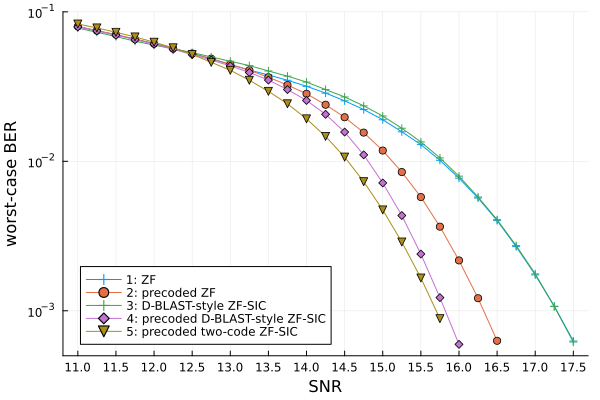

In [49]:
plot(Scen1_data[:,1], Scen1_data[:,2], marker=:auto, yaxis=:log, label="1: ZF", legend=:bottomleft)
plot!(Scen2_data[:,1], Scen2_data[:,2], marker=:auto, yaxis=:log, label="2: precoded ZF")
plot!(Scen3_data[:,1], Scen3_data[:,2], marker=:auto, yaxis=:log, label="3: D-BLAST-style ZF-SIC")
plot!(Scen4_data[:,1], Scen4_data[:,2], marker=:auto, yaxis=:log, label="4: precoded D-BLAST-style ZF-SIC")
plot!(Scen5_data[:,1], Scen5_data[:,2], marker=:auto, yaxis=:log, label="5: precoded two-code ZF-SIC")

ylims!(5e-4,1e-1)
yticks!([10.0^(-i) for i in 0:9])
ylabel!("worst-case BER")
xticks!(SNR_dBs[1:2:end])
xlabel!("SNR")
xticks!(0:0.5:20)

In [50]:
# savefig("Chase_PAM4_PDL.pdf");

In [51]:
# BERs_Scenx = BERs_Scen1
# BERs_Scenx_worst = BERs_Scen1_worst
# BERs_Scenx_best = BERs_Scen1_best

# plt = plot(SNR_dBs, BERs_Scenx_worst, marker=:auto, yaxis=:log, label="Scenx worst", legend=:bottomleft)
# # plot!(SNR_dBs, BERs_Scenx_best, marker=:auto, yaxis=:log, label="Scen1 best", legend=:bottomleft)
# ylims!(5e-5,5e-1)
# yticks!([10.0^(-i) for i in 0:9])
# ylabel!("BER")
# xticks!(SNR_dBs[1:2:end])
# xlabel!("SNR")
# xticks!(0:0.5:20)

# for i in 1:length(γs)
#     for j in 1:length(θs)
#         plot!(SNR_dBs, BERs_Scenx[i,j,:], marker=:auto, yaxis=:log, label="$(γs[i]) $(θs[j])", legend=:bottomleft)
#     end
# end
# display(plt)